In [1]:
# https://yadi.sk/d/OmpaRXt3hIq5Gg
import os
import numpy as np
import pydicom

# PathDicom = "./meddata/1/data/images/"
PathDicom = "./images/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(dirName+'/'+filename)
print (len(lstFilesDCM))

686


Use the first of the DICOM files to read in some of the metadata, specifically the image dimensions, the pixel-spacing, and the slice-thickness

In [2]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
# Calculate coordinate axes for this array 
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [3]:
%%time
# Load all the pixel data into an appropriate sized NumPy array named ArrayDicom
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

Wall time: 4.93 s


### Scrolling Image

In [4]:
# # Example
# from skimage import io
# struct_arr = io.imread("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/attention-mri.tif")

# %matplotlib nbagg
# import matplotlib.pyplot as plt
# plt.imshow(struct_arr[75], aspect=0.5)
# %matplotlib nbagg
# struct_arr2 = struct_arr.T
# plt.imshow(struct_arr2[34])

Use the matplotlib event handler API, which help to define actions to perform on the plot — including changing the plot’s data — in response to particular key presses or mouse button clicks.

Let’s bind the J and K keys on the keyboard to “previous slice” and “next slice”

- plot an arbitrary index, and store that index, maybe as an additional runtime attribute on the Axes object.
- provide functions next_slice and previous_slice that change the index and uses set_array to set the corresponding slice of the 3D volume.
- use the figure canvas draw method to redraw the figure with the new data.

In [7]:
import matplotlib.pyplot as plt
# !!!!! Important
%matplotlib nbagg

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

<IPython.core.display.Javascript object>


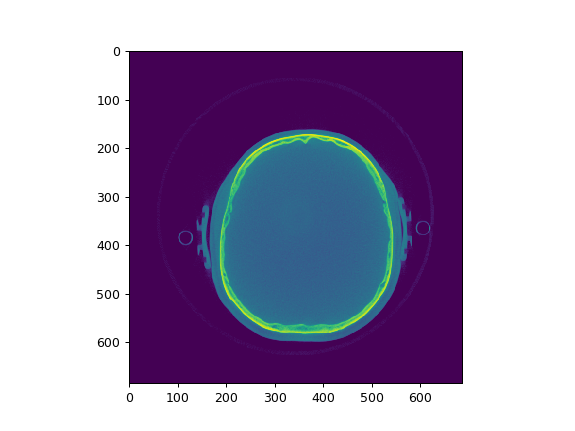

In [8]:
multi_slice_viewer(struct_arr.T)

<IPython.core.display.Javascript object>


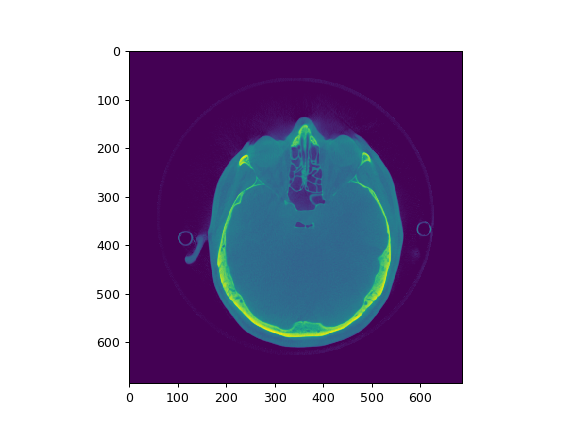

In [15]:
%matplotlib nbagg
plt.imshow(ArrayDicom[:,:,300])

<IPython.core.display.Javascript object>


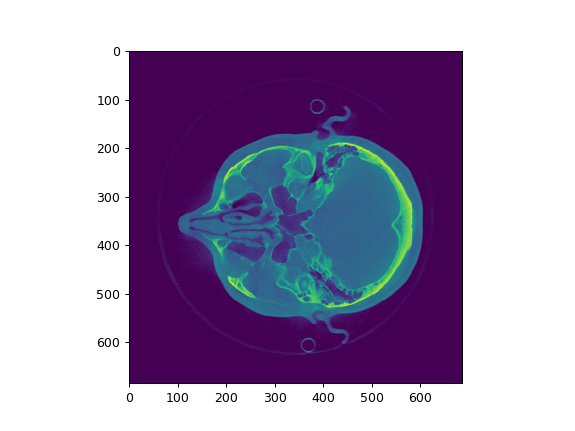

In [16]:
multi_slice_viewer(ArrayDicom.T)